## <font style="color:lightblue">Header</font>

### <font style="color:lightblue">Imports</font>

In [1]:
#%load_ext autoreload
#%autoreload 2

import math
import numpy as np
import torch
import torch.nn as nn
from torchinfo import summary
import itertools
import random
import os

import sinogap_module_long as sg




### <font style="color:lightblue">Redefine</font>

In [2]:
sg.plt.rcParams['figure.dpi']=223
sg.plt.rcParams['axes.spines.left'] = False
sg.plt.rcParams['axes.spines.right'] = False
sg.plt.rcParams['axes.spines.top'] = False
sg.plt.rcParams['axes.spines.bottom'] = False




### <font style="color:lightblue">Configs</font>

In [3]:
sg.set_seed(7)

sg.TCfg = sg.TCfgClass(
     exec = 0
    ,nofEpochs = None
    ,latentDim = 64
    ,batchSize = 2**12
    ,batchSplit = 2**2
    ,labelSmoothFac = 0.1 # For Fake labels (or set to 0.0 for no smoothing).
    ,learningRateD = 1e-4
    ,learningRateG = 1e-4
    ,dataDir = '/dev/shm/sinogapData'
)

sg.DCfg = sg.DCfgClass(2)

#os.environ["CTAS_MMAP_PATH"] = "/mnt/ssdData/"



### <font style="color:lightblue">Raw Read</font>

In [4]:
sg.trainSet = sg.createDataSet(sg.TCfg.dataDir, sg.listOfTrainData, exclusive=False)
sg.testSet = sg.createDataSet(sg.TCfg.dataDir+"/test", sg.listOfTestData, exclusive=True)


['/dev/shm/sinogapData/18692a.ExpChicken6mGyShift', '/dev/shm/sinogapData/23574.8965435L.Eiger.32kev_sft', '/dev/shm/sinogapData/19022g.11-EggLard', '/dev/shm/sinogapData/18692b.MinceO', '/dev/shm/sinogapData/23574.8965435L.Eiger.32kev_org', '/dev/shm/sinogapData/19736b.09_Feb.4176862R_Eig_Threshold-4keV', '/dev/shm/sinogapData/20982b.04_774784R', '/dev/shm/sinogapData/18515.Lamb1_Eiger_7m_45keV_360Scan', '/dev/shm/sinogapData/19736c.8733147R_Eig_Threshold-8keV.SAMPLE_Y1', '/dev/shm/sinogapData/18692b_input_PhantomM']
Loading train set 1 of 10: /dev/shm/sinogapData/18692a.ExpChicken6mGyShift ... Done
Loading train set 2 of 10: /dev/shm/sinogapData/23574.8965435L.Eiger.32kev_sft ... Done
Loading train set 3 of 10: /dev/shm/sinogapData/19022g.11-EggLard ... Done
Loading train set 4 of 10: /dev/shm/sinogapData/18692b.MinceO ... Done
Loading train set 5 of 10: /dev/shm/sinogapData/23574.8965435L.Eiger.32kev_org ... Done
Loading train set 6 of 10: /dev/shm/sinogapData/19736b.09_Feb.4176862R

### <font style="color:lightblue">Show</font>

(1, 48, 2161) 16164 (3641, 80)
2.174e-01, 3.770e-01, -4.472e-01, 5.151e-01


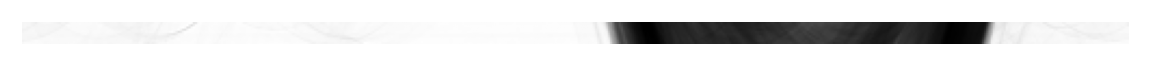

In [5]:
sg.refImages, sg.refNoises, sg.refBoxes = sg.createReferences(sg.testSet, 1)
sg.showMe(sg.testSet)


## <font style="color:lightblue">Models</font>

### Generator 2pix

In [6]:


class Generator2(sg.GeneratorTemplate):

    def __init__(self):
        super(Generator2, self).__init__(2)
        self.amplitude = 1
        self.encoders =  nn.ModuleList([
            self.encblock(  1/self.baseChannels,
                               1, (3,1),               padding=(1,0), norm=False),
            self.encblock(  1, 2, (3,3), stride=(2,1), padding=(1,0)),
            self.encblock(  2, 2, (3,1),               padding=(1,0)),
            self.encblock(  2, 4, (3,3), stride=(2,1), padding=(1,0)),
            self.encblock(  4, 4, (3,1),               padding=(1,0)),
            self.encblock(  4, 8, (3,3), stride=(2,1), padding=(1,0)),
            self.encblock(  8, 8, (3,1),               padding=(1,0)),
            self.encblock(  8,16, (3,1), stride=(2,1), padding=(1,0)),
            self.encblock( 16,16, (3,1),               padding=(1,0)),
            self.encblock( 16,16, (3,1), stride=(2,1), padding=(1,0)),
            self.encblock( 16,16, (3,1),               padding=(1,0)),
            self.encblock( 16,16, (3,1), stride=(2,1), padding=(1,0)),
            self.encblock( 16,16, (3,1),               padding=(1,0)),
            self.encblock( 16,16, (3,1), stride=(2,1), padding=(1,0)),
            self.encblock( 16,16, (3,1),               padding=(1,0)),
            ])
        self.fcLink = self.createFClink()
        self.decoders = nn.ModuleList([
            #self.decblock(2, 1, 3, stride=(2,1), outputPadding=(1,0), padding=(1,0)),
            #self.decblock(2, 1, 3, padding=1),
            #self.decblock(16, 4, 3, stride=(2,1), outputPadding=(1,0), padding=(1,0)),
            #self.decblock( 8, 4, 3, padding=1),
            self.decblock(32,16, (3,1),                                    padding=(1,0)),
            self.decblock(32,16, (3,1), stride=(2,1), outputPadding=(1,0), padding=(1,0)),
            self.decblock(32,16, (3,1),                                    padding=(1,0)),
            self.decblock(32,16, (3,1), stride=(2,1), outputPadding=(1,0), padding=(1,0)),
            self.decblock(32,16, (3,1),                                    padding=(1,0)),
            self.decblock(32,16, (3,1), stride=(2,1), outputPadding=(1,0), padding=(1,0)),
            self.decblock(32,16, (3,1),                                    padding=(1,0)),
            self.decblock(32, 8, (3,1), stride=(2,1), outputPadding=(1,0), padding=(1,0)),
            self.decblock(16, 8, (3,1),                                    padding=(1,0)),
            self.decblock(16, 4, (3,3), stride=(2,1), outputPadding=(1,0), padding=(1,0)),
            self.decblock( 8, 4, (3,1),                                    padding=(1,0)),
            self.decblock( 8, 2, (3,3), stride=(2,1), outputPadding=(1,0), padding=(1,0)),
            self.decblock( 4, 2, (3,1),                                    padding=(1,0)),
            self.decblock( 4, 1, (3,3), stride=(2,1), outputPadding=(1,0), padding=(1,0)),
            self.decblock( 2, 1, (3,1),                                    padding=(1,0), norm=False),
            ])
        self.lastTouch = self.createLastTouch()
        #sg.load_model(self, model_path="saves/gap2/noBNreNorm_SSIM/model_gen.pt" )

generator2 = Generator2()
generator2 = generator2.to(sg.TCfg.device)
#generator2 = generator2.requires_grad_(False)
generator2 = generator2.eval()
sg.lowResGenerators[2] = generator2



### <font style="color:lightblue">Generator</font>

In [7]:
sg.generator = sg.lowResGenerators[sg.DCfg.gapW]
sg.optimizer_G = sg.createOptimizer(sg.generator, sg.TCfg.learningRateG)
model_summary = summary(sg.generator, input_data=[ [sg.refImages[[0],...], sg.refNoises[[0],...]] ] ).__str__()
print(sg.refImages.shape, sg.refImages[[0],...].shape)
print(model_summary)


torch.Size([4, 1, 512, 10]) torch.Size([1, 1, 512, 10])
Layer (type:depth-idx)                   Output Shape              Param #
Generator2                               [1, 1, 512, 2]            --
├─ModuleList: 1-1                        --                        --
│    └─Sequential: 2-1                   [1, 4, 512, 10]           --
│    │    └─Conv2d: 3-1                  [1, 4, 512, 10]           16
│    │    └─LeakyReLU: 3-2               [1, 4, 512, 10]           --
│    └─Sequential: 2-2                   [1, 8, 256, 8]            --
│    │    └─Conv2d: 3-3                  [1, 8, 256, 8]            288
│    │    └─BatchNorm2d: 3-4             [1, 8, 256, 8]            16
│    │    └─LeakyReLU: 3-5               [1, 8, 256, 8]            --
│    └─Sequential: 2-3                   [1, 8, 256, 8]            --
│    │    └─Conv2d: 3-6                  [1, 8, 256, 8]            192
│    │    └─BatchNorm2d: 3-7             [1, 8, 256, 8]            16
│    │    └─LeakyReLU: 3-8 

### <font style="color:lightblue">Discriminator</font>

In [8]:

class Discriminator(sg.DiscriminatorTemplate):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.param = nn.Parameter(torch.zeros(1))
    def forward(self, images):
        return torch.zeros((images.shape[0],1), device=sg.TCfg.device)

sg.discriminator = Discriminator()
sg.discriminator = sg.discriminator.to(sg.TCfg.device)
model_summary = summary(sg.discriminator, input_data=sg.refImages[0,...] ).__str__()
print(model_summary)
#sg.writer.add_graph(sg.discriminator, refImages)

sg.optimizer_D = sg.createOptimizer(sg.discriminator, sg.TCfg.learningRateD)



Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1]                    1
Total params: 1
Trainable params: 1
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 0.08
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.08


## <font style="color:lightblue">Norms</font>

In [9]:
sg.dataLoader = sg.createDataLoader(sg.trainSet, shuffle=True, num_workers=16)
sg.testLoader = sg.createDataLoader(sg.testSet, shuffle=False, num_workers=16)

#_ = sg.summarizeMe(sg.testLoader, True)
#_ = sg.summarizeMe(sg.testLoader, False)
#_ = sg.summarizeMe(sg.dataLoader, True)
#_ = sg.summarizeMe(sg.dataLoader, False)
#sg.displayImages()


## <font style="color:lightblue">Restore checkpoint</font>

Initial LR : G 1.000e-04 (1.0000)


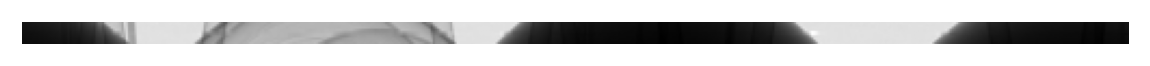

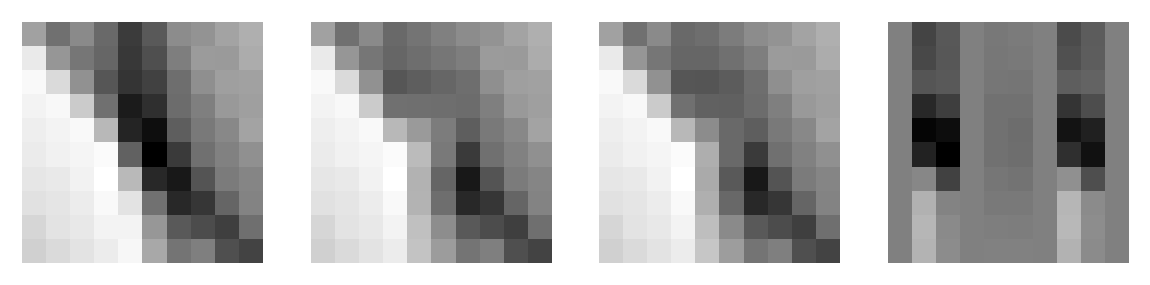

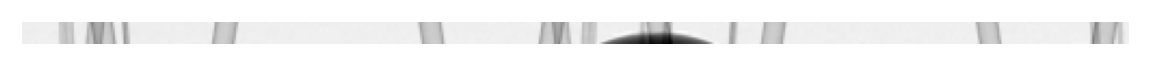

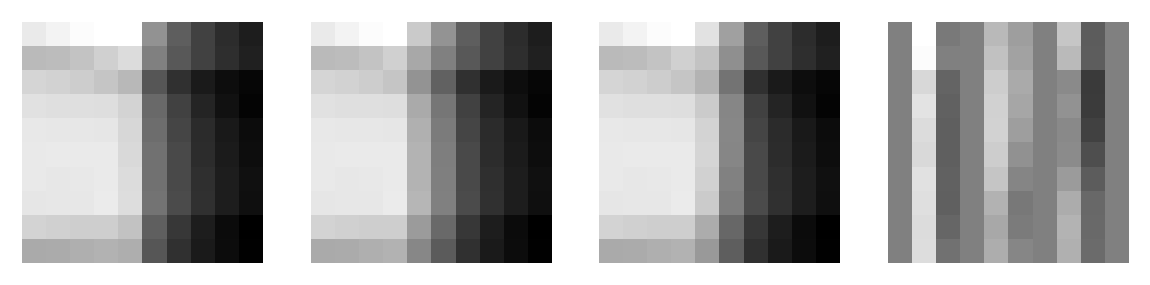

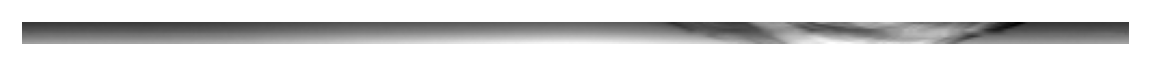

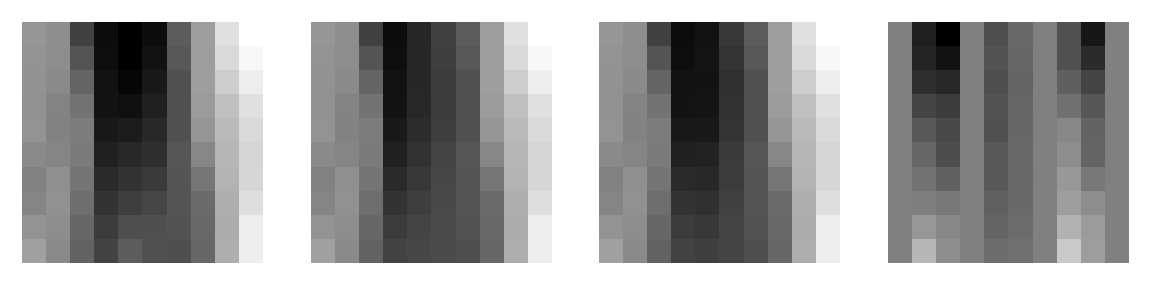

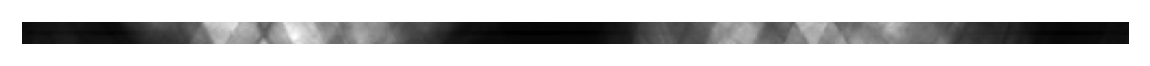

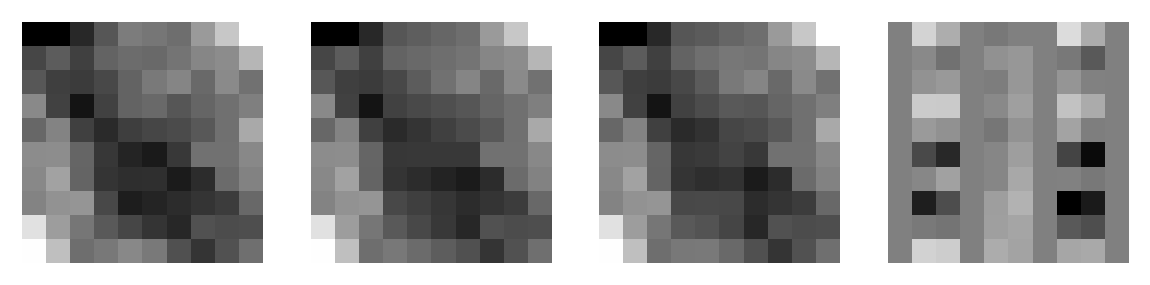

In [ ]:

sg.scheduler_G = torch.optim.lr_scheduler.StepLR(sg.optimizer_G, 1, gamma=1)
#sg.scheduler_D = torch.optim.lr_scheduler.StepLR(sg.optimizer_D, 1, gamma=1)
savedCheckPoint = f"checkPoint_{sg.TCfg.exec}"
sg.epoch, sg.imer, sg.minGEpoch, sg.minGLoss, sg.startFrom, sg.resAcc = \
    sg.restoreCheckpoint(savedCheckPoint+".pth")
#sg.epoch, sg.imer, sg.minGEpoch, sg.minGdLoss, sg.startFrom = 0, 0, 0, 1, 0
sg.writer = sg.createWriter(sg.TCfg.logDir, True)
#sg.writer.add_graph(sg.generator, ((sg.refImages, sg.refNoises),) )
#sg.writer.add_graph(sg.discriminator, refImages)

sg.scheduler_G.gamma = 1-0.005
#sg.scheduler_D.gamma = 1-0.005
sg.optimizer_G.step()
#sg.optimizer_D.step()
#torch.optim.lr_scheduler.LambdaLR(sg.optimizer_G, lambda epoch: 0.1).step()
#torch.optim.lr_scheduler.LambdaLR(sg.optimizer_D, lambda epoch: 0.05).step()


print(f"Initial LR : G {sg.scheduler_G.get_last_lr()[0]:.3e} ({sg.scheduler_G.get_last_lr()[0]/sg.TCfg.learningRateG:.4f})")
                  #f" D {sg.scheduler_D.get_last_lr()[0]:.3e} ({sg.scheduler_D.get_last_lr()[0]/sg.TCfg.learningRateD:.4f}), Epoch {sg.epoch} {sg.imer}")
sg.displayImages()
#_ = sg.summarizeMe(sg.testLoader, False)
sg.minGLoss = None

## <font style="color:lightblue">Execute</font>

GLR : 6.663e-05 (0.670). 
Epoch: 7 (0).  Images: 36864. DIS: 0.000e+00, GEN: 8.653e+00. Probs: True 0.000e+00, Fake 0.000e+00.
Individual losses: Adv: 0.000e+00  MSE: 8.653e+00  L1L: 1.759e+00  SSIM: 1.072e+00  MSSSIM: 6.055e-01 



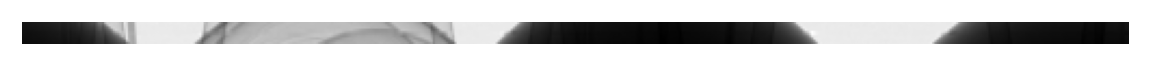

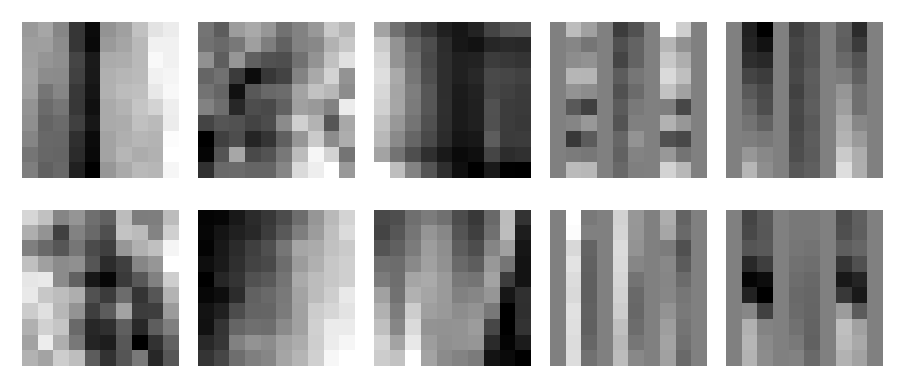

  2%|▏         | 57/3219 [00:56<38:43,  1.36it/s] 

In [ ]:



def my_beforeReport(sglocals) :
    message = ""
    message += "G" + sg.adjustScheduler(sg.scheduler_G, sg.TCfg.learningRateG, 0.1)
    with open(f"message_{sg.TCfg.exec}.txt", 'a') as file:
        file.write(message + "\n")
    print(message)
    return
sg.beforeReport = my_beforeReport


try :
    sg.train(savedCheckPoint)
except :
    #del sg.dataLoader
    #del sg.testLoader
    sg.freeGPUmem()
    1/10 # to release Jupyuter memory in the next step
    sg.epoch -= 1
    raise



## <font style="color:lightblue">Post</font>

In [ ]:
print (sg.generator.amplitude.item(), 2 * torch.sigmoid(sg.generator.amplitude).item() )
sg.initialTest()


In [ ]:
sg.testMe(trainSet, 5)

### <font style="color:lightblue">Save results</font>

In [ ]:
sg.saveModels()